# `StableSpectralElements.jl` - 2D Euler example using entropy-stable  discretization

First, let's load the packages used in this example.

In [20]:
using StableSpectralElements, OrdinaryDiffEq
using Plots, Plots.PlotMeasures, TimerOutputs, StaticArrays, BenchmarkTools

We will be solving the two-dimensional compressible Euler equations, which are a hyperbolic system of conservation laws given by
$$
\begin{aligned}
\partial_t \rho(\boldsymbol{x},t) + \nabla_{\boldsymbol{x}} \cdot ( \rho(\boldsymbol{x},t) \boldsymbol{V}(\boldsymbol{x},t)) &= 0,\\
\partial_t ( \rho(\boldsymbol{x},t) \boldsymbol{V}(\boldsymbol{x},t)) + \nabla_{\boldsymbol{x}} \cdot ( \rho(\boldsymbol{x},t) \boldsymbol{V}(\boldsymbol{x},t) \otimes \boldsymbol{V}(\boldsymbol{x},t) + P(\boldsymbol{x},t)\boldsymbol{I}) &= \boldsymbol{0},\\
\partial_t E(\boldsymbol{x},t) + \nabla_{\boldsymbol{x}} \cdot ((E(\boldsymbol{x},t) + P(\boldsymbol{x},t))\boldsymbol{V}(\boldsymbol{x},t)) &= 0,
\end{aligned}
$$
with 
$$
 P(\boldsymbol{x},t) = (\gamma - 1)\big(E(\boldsymbol{x},t) - \tfrac{1}{2} \rho(\boldsymbol{x},t) \lVert \boldsymbol{V}(\boldsymbol{x},t) \rVert^2 \big),
$$
where $\gamma = 1.4$ is the specific heat ratio. The initial condition is an isentropic vortex in a uniform flow on the domain $\Omega = (0,1)^2$ with periodic boundary conditions, at a  Mach number of 0.4. The density field is shown below.

![620x400](figures/euler_initial_condition.png)

In [21]:
mach_number = 0.4
angle = 0.0
L = 1.0
γ=1.4
T = L/mach_number # end time
strength = sqrt(2/(γ-1)*(1-0.75^(γ-1))) # for central value of ρ=0.75

conservation_law = EulerEquations{2}(γ)
exact_solution = IsentropicVortex(conservation_law, θ=angle,
    Ma=mach_number, β=strength, R=1.0/10.0, x_0=(L/2,L/2));

Let's discretize the above problem using a `ModalMulti` discretization of degree $p = 4$ on an isoparametrically warped triangular mesh with $M = 4$ edges in each direction. We will use an entropy-stable flux-differencing scheme employing [Ranocha's two-point flux](https://link.springer.com/chapter/10.1007/978-3-030-39647-3_42) and Lax-Friedrichs interface dissipation; to obtain an entropy-conservative scheme, one can instead take `inviscid_numerical_flux=EntropyConservativeNumericalFlux()`. The modal (i.e. non-collocated) formulation necessitates the introduction of an "entropy projection" procedure as well as a facet correction equivalent to the use of hybridized/decoupled SBP operators as proposed by [Chan (2018)](https://arxiv.org/abs/1708.01243).

In [22]:
p = 4
M = 4

form = FluxDifferencingForm(inviscid_numerical_flux=LaxFriedrichsNumericalFlux())

reference_approximation = ReferenceApproximation(ModalMulti(p), Tri(), mapping_degree=p)

uniform_mesh = uniform_periodic_mesh(reference_approximation, ((0.0,L),(0.0,L)), (M,M))

mesh = warp_mesh(uniform_mesh, reference_approximation, ChanWarping(1.0/16, (L,L)))

spatial_discretization = SpatialDiscretization(mesh, reference_approximation)

results_path = save_project(conservation_law,
    spatial_discretization, exact_solution, form, (0.0, T),
    "results/euler_vortex_2d/", overwrite=true, clear=true)

ode = semidiscretize(conservation_law, spatial_discretization, 
    exact_solution, form, (0.0, T), parallelism=Serial());

We'll now plot the mesh, showing the volume and facet quadrature nodes.

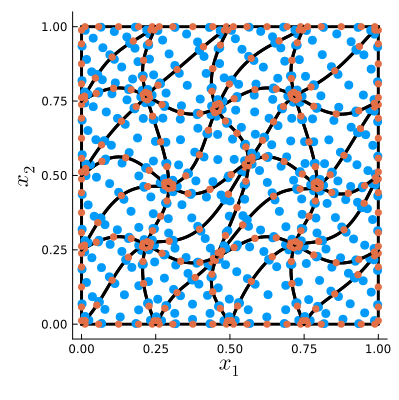

In [23]:
plot(spatial_discretization, fmt=:png)

The resulting system of ordinary differential equations can then be solved as usual using OrdinaryDiffEq.jl's `solve` function.

In [24]:
C_t = 0.25
dt = C_t * (L/M) / (mach_number*p^2)
reset_timer!()
sol = solve(ode, DP8(), adaptive=false, dt=dt, save_everystep=false, 
    callback=save_callback(results_path, (0.0,T), 5))
print_timer()

 ────────────────────────────────────────────────────────────────────────────────
                                        Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:            2.02s /  97.1%            385MiB /  99.0%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 semi-disc. residual    4.20k    1.96s  100.0%   466μs    382MiB  100.0%  93.0KiB
   time deriv.           134k    1.16s   59.2%  8.63μs     0.00B    0.0%    0.00B
   nodal values          134k    775ms   39.6%  5.77μs    382MiB  100.0%  2.91KiB
 ────────────────────────────────────────────────────────────────────────────────


The $L^2$ error in each conservative variable (i.e. $\rho$, $\rho V_1$, $\rho V_2$, and $E$) can be computed as follows.

In [36]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
println("L2 error: ", analyze(error_analysis, last(sol.u), exact_solution, T))

L2 error: [0.009677753260464819, 0.024496820763504023, 0.028850498628278702, 0.024774662901463733]


We'll now verify that the mass conservation and entropy residuals are zero and non-positive, respectively.

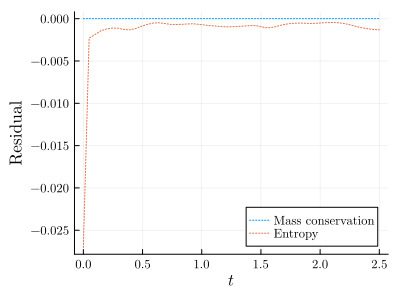

In [26]:
time_steps = load_time_steps(results_path)
conservation = analyze(PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization), time_steps, normalize=false)
entropy = analyze(EntropyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization), time_steps)

conservation_plot = plot(conservation, ylabel="Residual", 1, 
    net_change=false, label="Mass conservation", size=(400,300), fmt=:png)
plot!(conservation_plot, entropy, net_change=false, label="Entropy")


We can now visualize the density field as a `.vtu` file, for example, in ParaView.

In [27]:
for i in eachindex(sol.u)
    postprocess_vtk(spatial_discretization, string(results_path,
        "solution_",i,".vtu"), sol.u[i], variable_name="Density")
end